In [1]:
import geopandas as gpd 
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import datetime as dt 
from shapely.geometry import Point, Polygon
import sys
import glob 
import os 
from scipy import stats 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
import seaborn as sns
import copy

files_path = "C:/Users/Michael Ip/TDI/Capstone_Project/citibike_tripdata/2015_04_to_2015_05"
read_files = glob.glob(os.path.join(files_path,"*.csv"))

li = []

for file in read_files: 
    df = pd.read_csv(file, index_col = None, header = 0)
    li.append(df)
    
df = pd.concat(li, axis = 0, ignore_index = True)
gpd_df = gpd.read_file("C:/Users/Michael Ip/TDI/Capstone_Project/citibike_tripdata/Neighborhood Tabulation Areas/geo_export_4f2d36a9-dd43-452a-9f81-a97957389244.shp")

In [2]:
df["starttime"] = pd.to_datetime(df["starttime"], infer_datetime_format = True)
df["stoptime"] = pd.to_datetime(df["stoptime"], infer_datetime_format = True)
df["trip duration minutes"] = df["tripduration"]/60

df["user type number"] = 1
df.loc[df["usertype"] != "Subscriber", "user type number"] = 0

In [3]:
def get_distance(start_lat, start_long, end_lat, end_long): 
    radius = 6371 
    avg_lat = (start_lat + end_lat)/2 * (np.pi/180)
    delta_lat = (end_lat - start_lat) * (np.pi/180)
    delta_long = (end_long - start_long) * (np.pi/180)
    
    distance = radius*np.sqrt(delta_lat**2 + (np.cos(avg_lat)*delta_long)**2)
    return distance

df["age"] = 2015 - df["birth year"]

df["round trip"] = "yes"
df.loc[df["start station name"] != df["end station name"], "round trip"] = "no" 

df["distance traveled"] = get_distance(df["start station latitude"], 
                                       df["start station longitude"], 
                                       df["end station latitude"], 
                                       df["end station longitude"])

"""
def roundtrip(row): 
    if row["start station name"] == row["end station name"]: 
        val = "round trip"
    else: 
        val = "not round trip"
    return val

df["round trip"] = df.apply(roundtrip, axis = 1)
"""

'\ndef roundtrip(row): \n    if row["start station name"] == row["end station name"]: \n        val = "round trip"\n    else: \n        val = "not round trip"\n    return val\n\ndf["round trip"] = df.apply(roundtrip, axis = 1)\n'

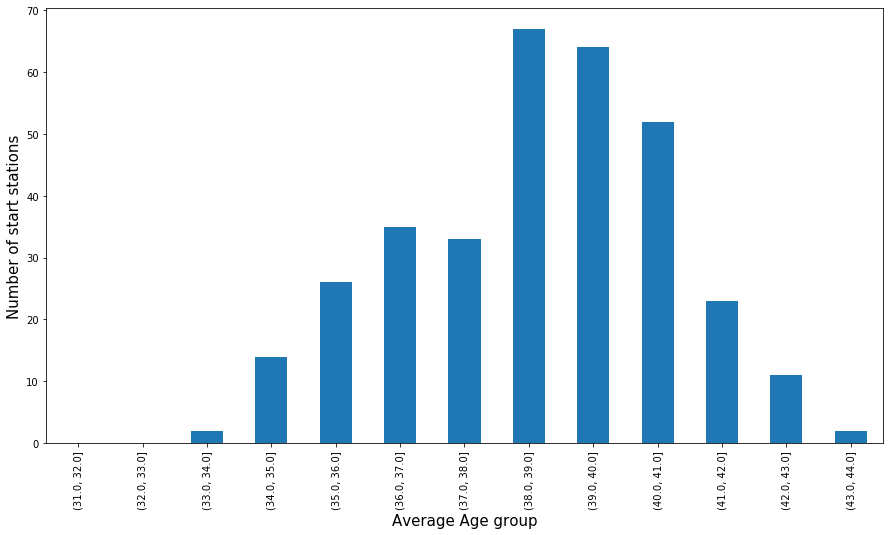

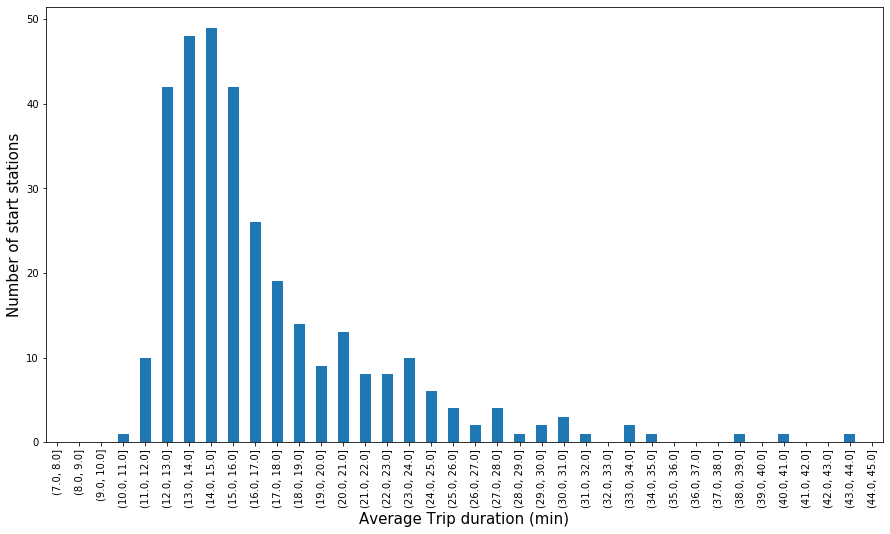

   start station name   mean age      age bins
16    8 Ave & W 31 St  43.036795  (43.0, 44.0]
72          Cherry St  43.471649  (43.0, 44.0]


In [4]:
groups = df.groupby(by = "start station name")["age"].agg(["mean"]).reset_index()
groups = groups.rename(columns = {"mean" : "mean age"})

groups2 = df.groupby(by = "start station name")["trip duration minutes"].agg(["mean"]).reset_index()
groups2 = groups2.rename(columns = {"mean" : "mean trip duration"})

fig, ax = plt.subplots(figsize = (15,8))
age_bin = np.linspace(31, 44, 14)
groups["age bins"] = pd.cut(x = groups["mean age"], bins = age_bin)
groups["age bins"].value_counts(sort = False).plot.bar()
ax.set_xlabel("Average Age group", fontsize = 15)
ax.set_ylabel("Number of start stations", fontsize = 15)
plt.show()

fig, ax = plt.subplots(figsize = (15,8))
tripduration_bin = np.linspace(7, 45, 39)
groups2["trip duration bins"] = pd.cut(x = groups2["mean trip duration"], bins = tripduration_bin)
groups2["trip duration bins"].value_counts(sort = False).plot.bar()
ax.set_xlabel("Average Trip duration (min)", fontsize = 15)
ax.set_ylabel("Number of start stations", fontsize = 15)
plt.show()


#print (groups)
print (groups[groups["mean age"] > 43])

In [12]:
groups.head()

,start station name,mean age,age bins
0,1 Ave & E 15 St,35.678921,"(35.0, 36.0]"
1,1 Ave & E 18 St,35.985136,"(35.0, 36.0]"
2,1 Ave & E 30 St,37.208463,"(37.0, 38.0]"
3,1 Ave & E 44 St,42.275639,"(42.0, 43.0]"
4,10 Ave & W 28 St,36.665891,"(36.0, 37.0]"


In [10]:
stations_gdf = gpd.GeoDataFrame(df["start station name"].unique(), 
                                geometry = gpd.points_from_xy(df["start station longitude"].unique(), 
                                                              df["start station latitude"].unique()))

stations_gdf = stations_gdf.rename(columns = {0 : "start station name"})
stations_gdf = pd.merge(stations_gdf, groups, how = "outer", on = "start station name")
stations_gdf = pd.merge(stations_gdf, groups2, how = "outer", on ="start station name")

In [11]:
stations_gdf.head()

,start station name,geometry,mean age,age bins,mean trip duration,trip duration bins
0,W 26 St & 8 Ave,POINT (-73.99724 40.74735),40.313446,"(40.0, 41.0]",13.144556,"(13.0, 14.0]"
1,St James Pl & Pearl St,POINT (-74.00017 40.71117),38.843729,"(38.0, 39.0]",15.783405,"(15.0, 16.0]"
2,W 13 St & 7 Ave,POINT (-73.99995 40.73782),39.785314,"(39.0, 40.0]",12.934452,"(12.0, 13.0]"
3,E 5 St & Avenue C,POINT (-73.97995 40.72299),36.128355,"(36.0, 37.0]",13.624979,"(13.0, 14.0]"
4,W 16 St & The High Line,POINT (-74.00682 40.74335),39.830683,"(39.0, 40.0]",17.683305,"(17.0, 18.0]"


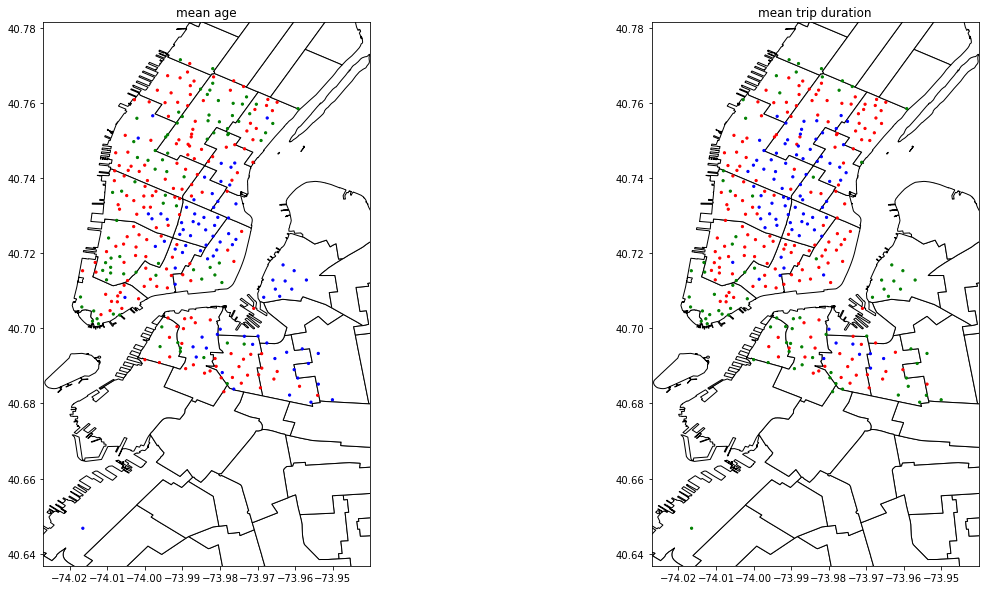

In [7]:
quantile_age_0 = stations_gdf["mean age"].quantile(0)
quantile_age_10 = stations_gdf["mean age"].quantile(0.10)
quantile_age_25 = stations_gdf["mean age"].quantile(0.25)
quantile_age_50 = stations_gdf["mean age"].quantile(0.50)
quantile_age_75 = stations_gdf["mean age"].quantile(0.75)
quantile_age_90 = stations_gdf["mean age"].quantile(0.90)
quantile_age_1 = stations_gdf["mean age"].quantile(1)

quantile_TD_0 = stations_gdf["mean trip duration"].quantile(0)
quantile_TD_10 = stations_gdf["mean trip duration"].quantile(0.10)
quantile_TD_25 = stations_gdf["mean trip duration"].quantile(0.25)
quantile_TD_50 = stations_gdf["mean trip duration"].quantile(0.50)
quantile_TD_75 = stations_gdf["mean trip duration"].quantile(0.75)
quantile_TD_90 = stations_gdf["mean trip duration"].quantile(0.90)
quantile_TD_1 = stations_gdf["mean trip duration"].quantile(1)

age_std = stations_gdf["mean age"].std()
TD_std = stations_gdf["mean trip duration"][stations_gdf["mean trip duration"] < 26].std()
age_mean = stations_gdf["mean age"].mean()
TD_mean = stations_gdf["mean trip duration"].mean()

def colorfunc_age(row): 
    if row["mean age"] < quantile_age_25: 
        val = "b"
    elif (quantile_age_25 <= row["mean age"] < quantile_age_75):
        val = "r"
    else: 
        val = "g"
    return val 

def colorfunc_trip_duration(row): 
    if row["mean trip duration"] < quantile_TD_25: 
        val = "b"
    elif (quantile_TD_25 <= row["mean trip duration"] < quantile_TD_75):
        val = "r"
    else: 
        val = "g"
    return val 

stations_gdf["age bin color"] = stations_gdf.apply(colorfunc_age, axis = 1) 
stations_gdf["trip duration bin color"] = stations_gdf.apply(colorfunc_trip_duration, axis = 1)

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))
ax1.set_title("mean age")
gpd_df[(gpd_df["boro_name"] == "Manhattan") | (gpd_df["boro_name"] == "Brooklyn")].plot(ax = ax1, figsize = (20,10), color = "white", edgecolor = "black")
stations_gdf.plot(ax=ax1, color = stations_gdf["age bin color"], markersize = 5 )

ax2.set_title("mean trip duration")
gpd_df[(gpd_df["boro_name"] == "Manhattan") | (gpd_df["boro_name"] == "Brooklyn")].plot(ax = ax2, figsize = (20,10), color = "white", edgecolor = "black")
stations_gdf.plot(ax=ax2, color = stations_gdf["trip duration bin color"], markersize = 5 )

minx, miny, maxx, maxy = stations_gdf.total_bounds
ax1.set_xlim(minx - 0.01, maxx + 0.01)
ax1.set_ylim(miny - 0.01, maxy + 0.01)

ax2.set_xlim(minx - 0.01, maxx + 0.01)
ax2.set_ylim(miny - 0.01, maxy + 0.01)

plt.show()

In [8]:
stations_gdf.head()

,start station name,geometry,mean age,age bins,mean trip duration,trip duration bins,age bin color,trip duration bin color
0,W 26 St & 8 Ave,POINT (-73.99724 40.74735),40.313446,"(40.0, 41.0]",13.144556,"(13.0, 14.0]",g,b
1,St James Pl & Pearl St,POINT (-74.00017 40.71117),38.843729,"(38.0, 39.0]",15.783405,"(15.0, 16.0]",r,r
2,W 13 St & 7 Ave,POINT (-73.99995 40.73782),39.785314,"(39.0, 40.0]",12.934452,"(12.0, 13.0]",r,b
3,E 5 St & Avenue C,POINT (-73.97995 40.72299),36.128355,"(36.0, 37.0]",13.624979,"(13.0, 14.0]",b,r
4,W 16 St & The High Line,POINT (-74.00682 40.74335),39.830683,"(39.0, 40.0]",17.683305,"(17.0, 18.0]",r,r


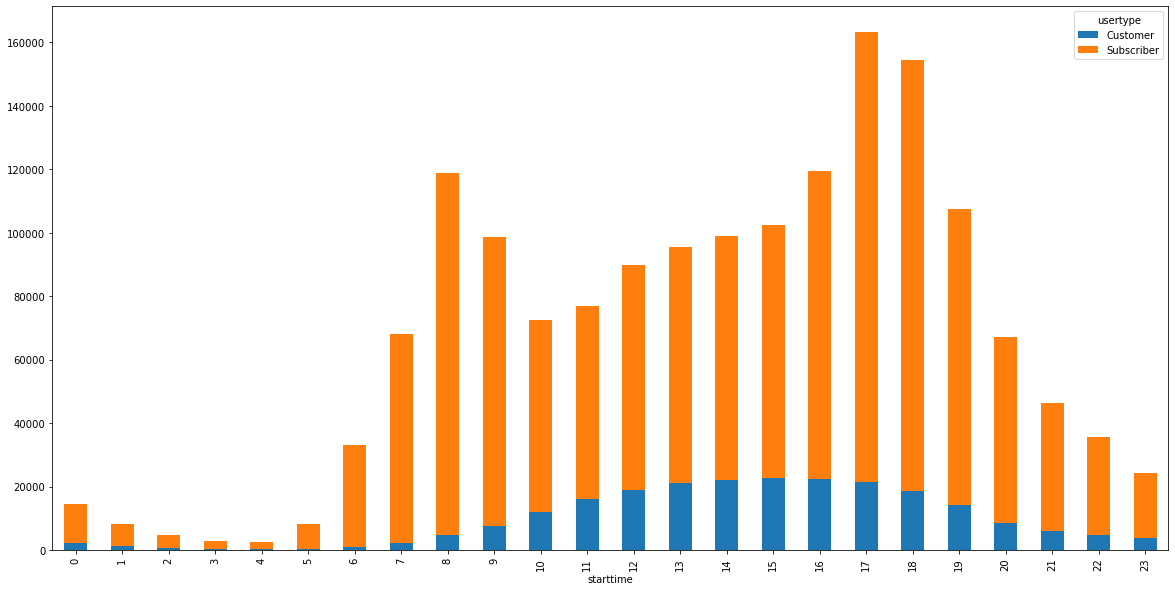

In [10]:
df["starttime"].groupby([df["starttime"].dt.hour, df["usertype"]]).count().unstack().plot(kind = "bar", figsize = (20,10), stacked = True)

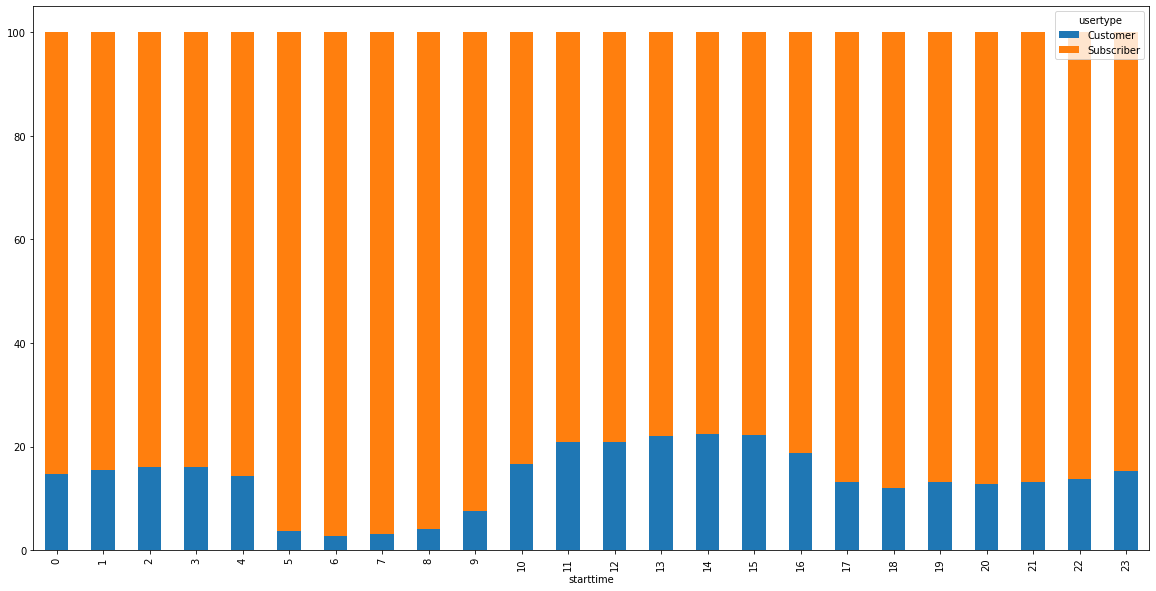

In [11]:
group_hour_usertype = df["starttime"].groupby([df["starttime"].dt.hour, df["usertype"]]).count()
group_hour_usertype_percentage = group_hour_usertype.groupby(level = 0).apply(lambda x: 100*x/float(x.sum()))
group_hour_usertype_percentage.unstack().plot(kind = "bar", stacked = True, figsize = (20,10))

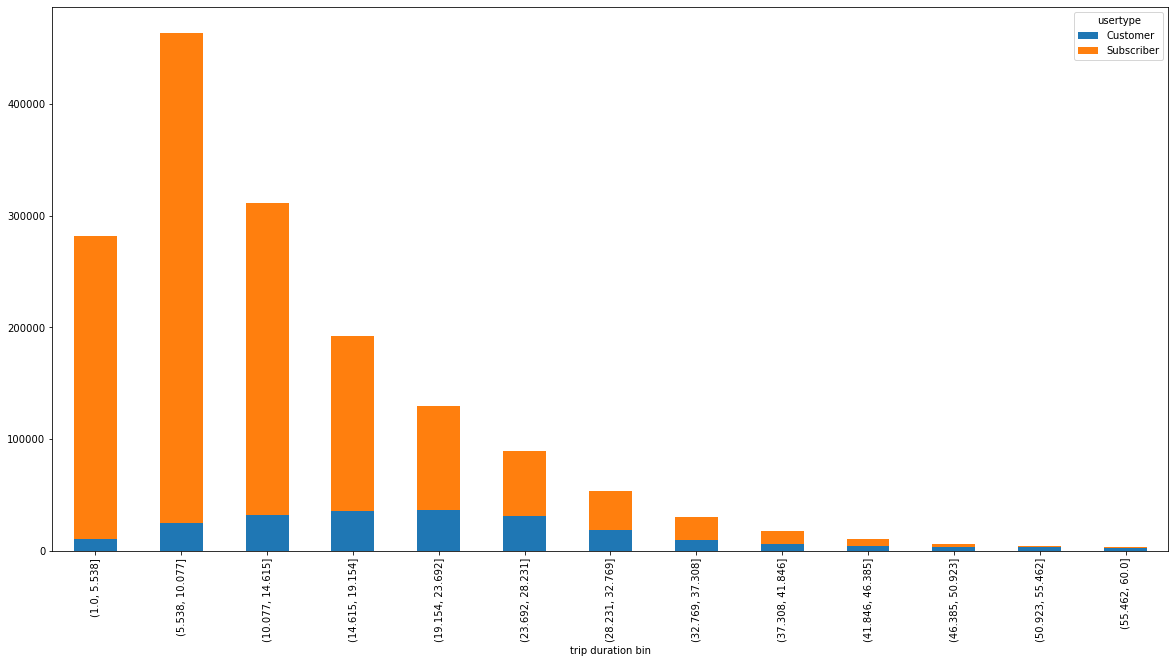

In [83]:
test["trip duration bin"].groupby([test["trip duration bin"], test["usertype"]]).count().unstack().plot(kind = "bar", figsize = (20,10), stacked = True)

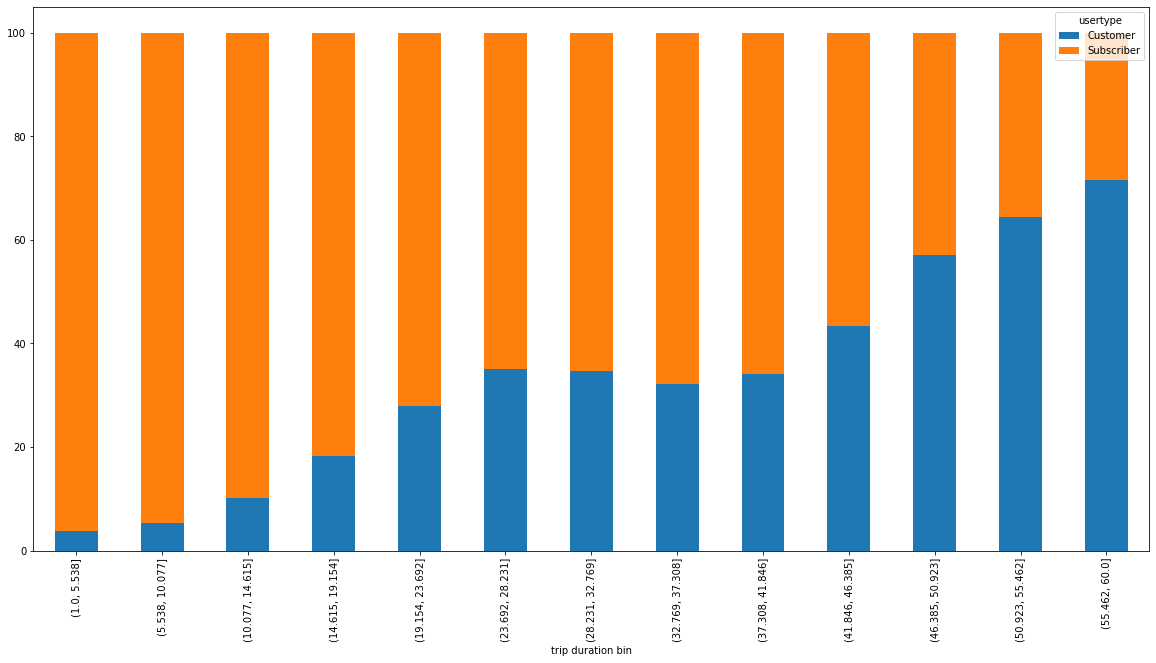

In [82]:

group_td_usertype = test["trip duration bin"].groupby([test["trip duration bin"], test["usertype"]]).count()
group_td_usertype_percentage = group_td_usertype.groupby(level = 0).apply(lambda x: 100*x/float(x.sum()))
group_td_usertype_percentage.unstack().plot(kind = "bar", stacked = True, figsize = (20,10))

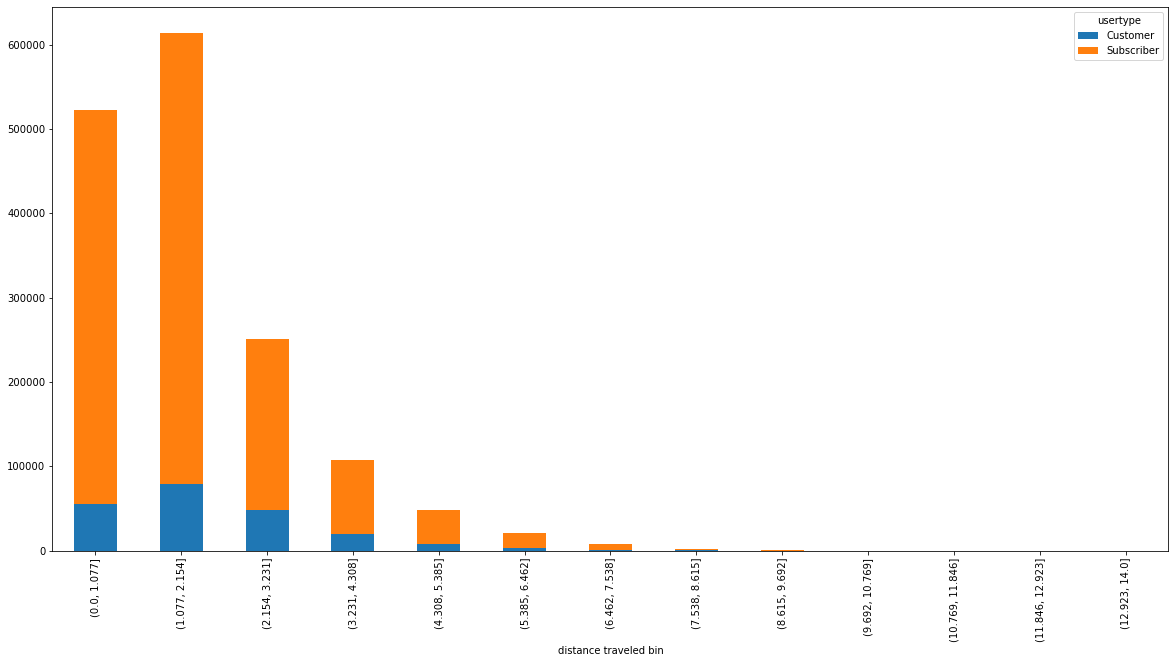

In [113]:
test["distance traveled bin"].groupby([test["distance traveled bin"], test["usertype"]]).count().unstack().plot(kind = "bar", figsize = (20,10), stacked = True)

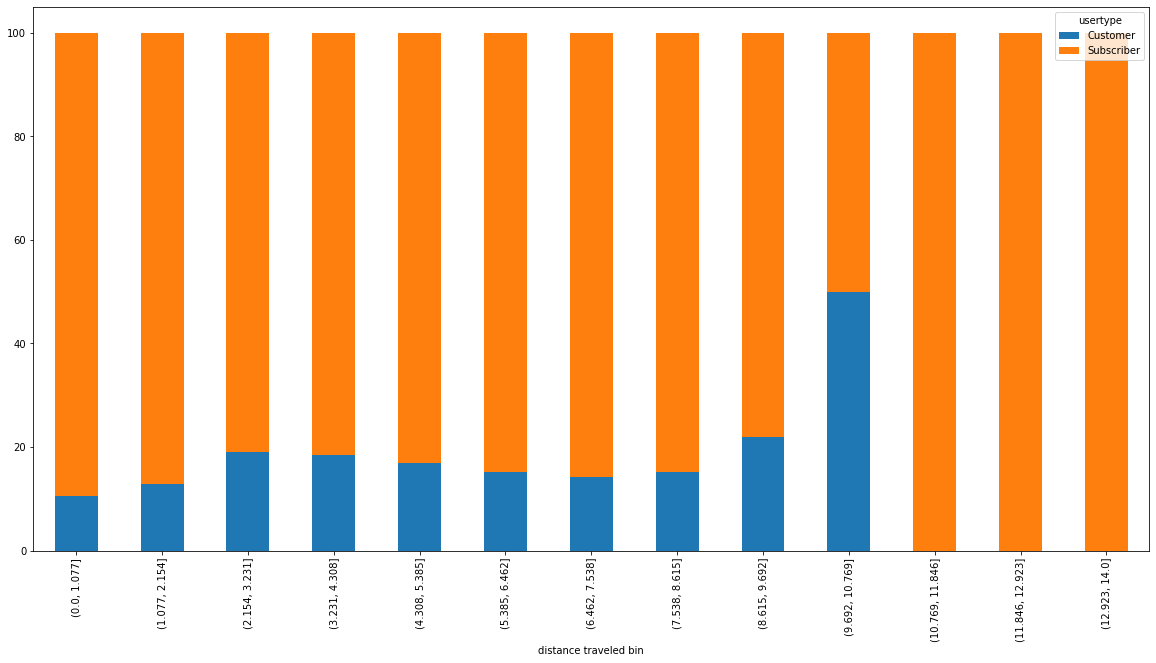

In [112]:

group_distance_usertype = test["distance traveled bin"].groupby([test["distance traveled bin"], test["usertype"]]).count()
group_distance_usertype_percentage = group_distance_usertype.groupby(level = 0).apply(lambda x: 100*x/float(x.sum()))
group_distance_usertype_percentage.unstack().plot(kind = "bar", stacked = True, figsize = (20,10))

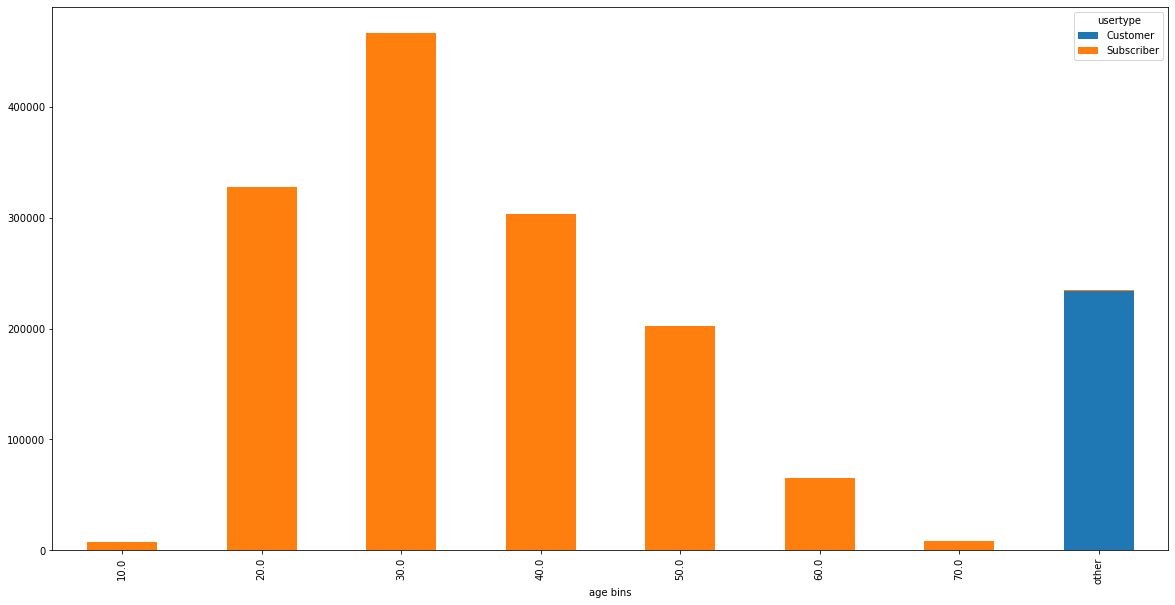

In [47]:
test["age bins"].groupby([test["age bins"], test["usertype"]]).count().unstack().plot(kind = "bar", figsize = (20,10), stacked = True)

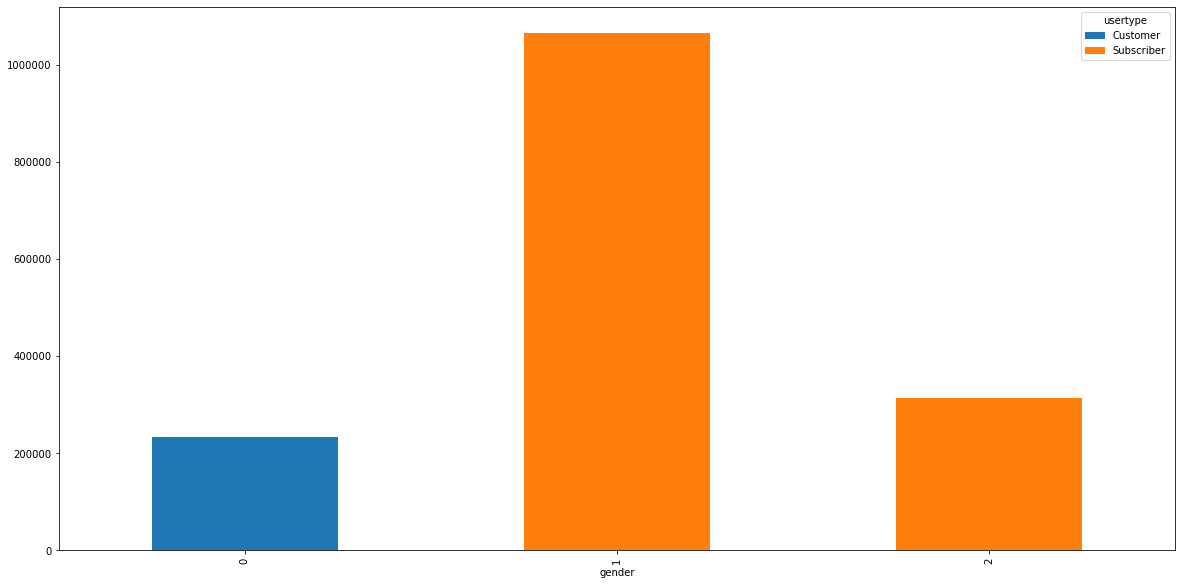

In [57]:
test["gender"].groupby([test["gender"], test["usertype"]]).count().unstack().plot(kind = "bar", figsize = (20,10), stacked = True)

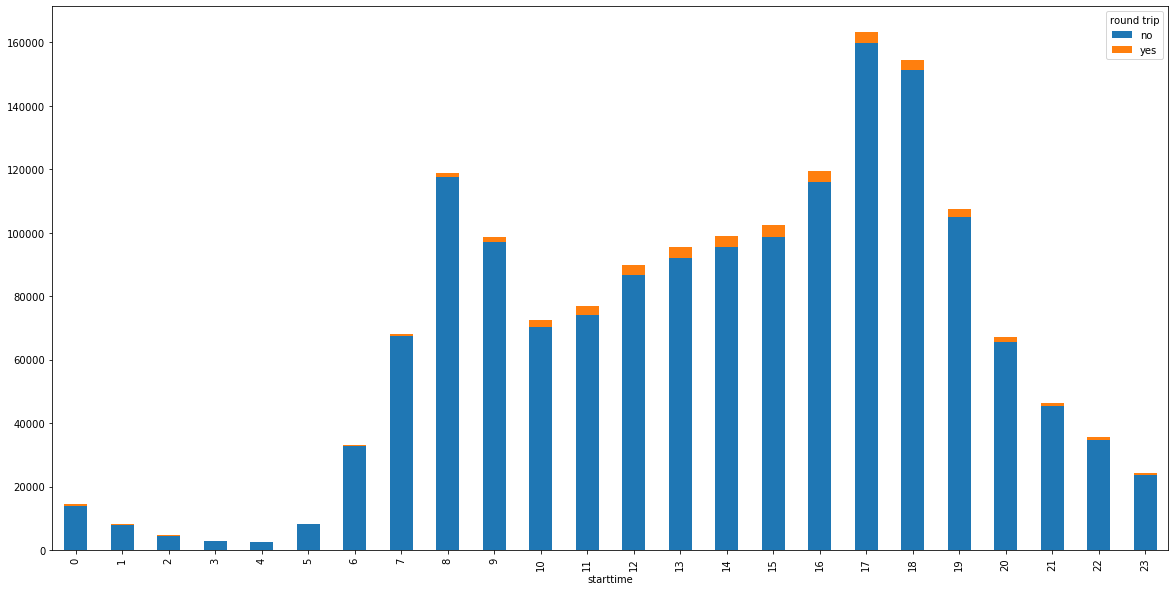

In [12]:
df["starttime"].groupby([df["starttime"].dt.hour, df["round trip"]]).count().unstack().plot(kind = "bar", figsize = (20,10), stacked = True)

In [13]:
df.groupby([df["start station name"], df["end station name"]]).size().reset_index(name = "Number of trips").nlargest(10, "Number of trips")

,start station name,end station name,Number of trips
16943,Central Park S & 6 Ave,Central Park S & 6 Ave,4246
14794,Broadway & W 60 St,Broadway & W 60 St,1742
41694,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,1453
2276,12 Ave & W 40 St,West St & Chambers St,869
16938,Central Park S & 6 Ave,Broadway & W 60 St,817
14540,Broadway & W 58 St,Broadway & W 58 St,787
65267,W 21 St & 6 Ave,9 Ave & W 22 St,772
17195,Centre St & Chambers St,Centre St & Chambers St,768
37785,E 7 St & Avenue A,Lafayette St & E 8 St,763
41608,Grand Army Plaza & Central Park S,Broadway & W 60 St,759


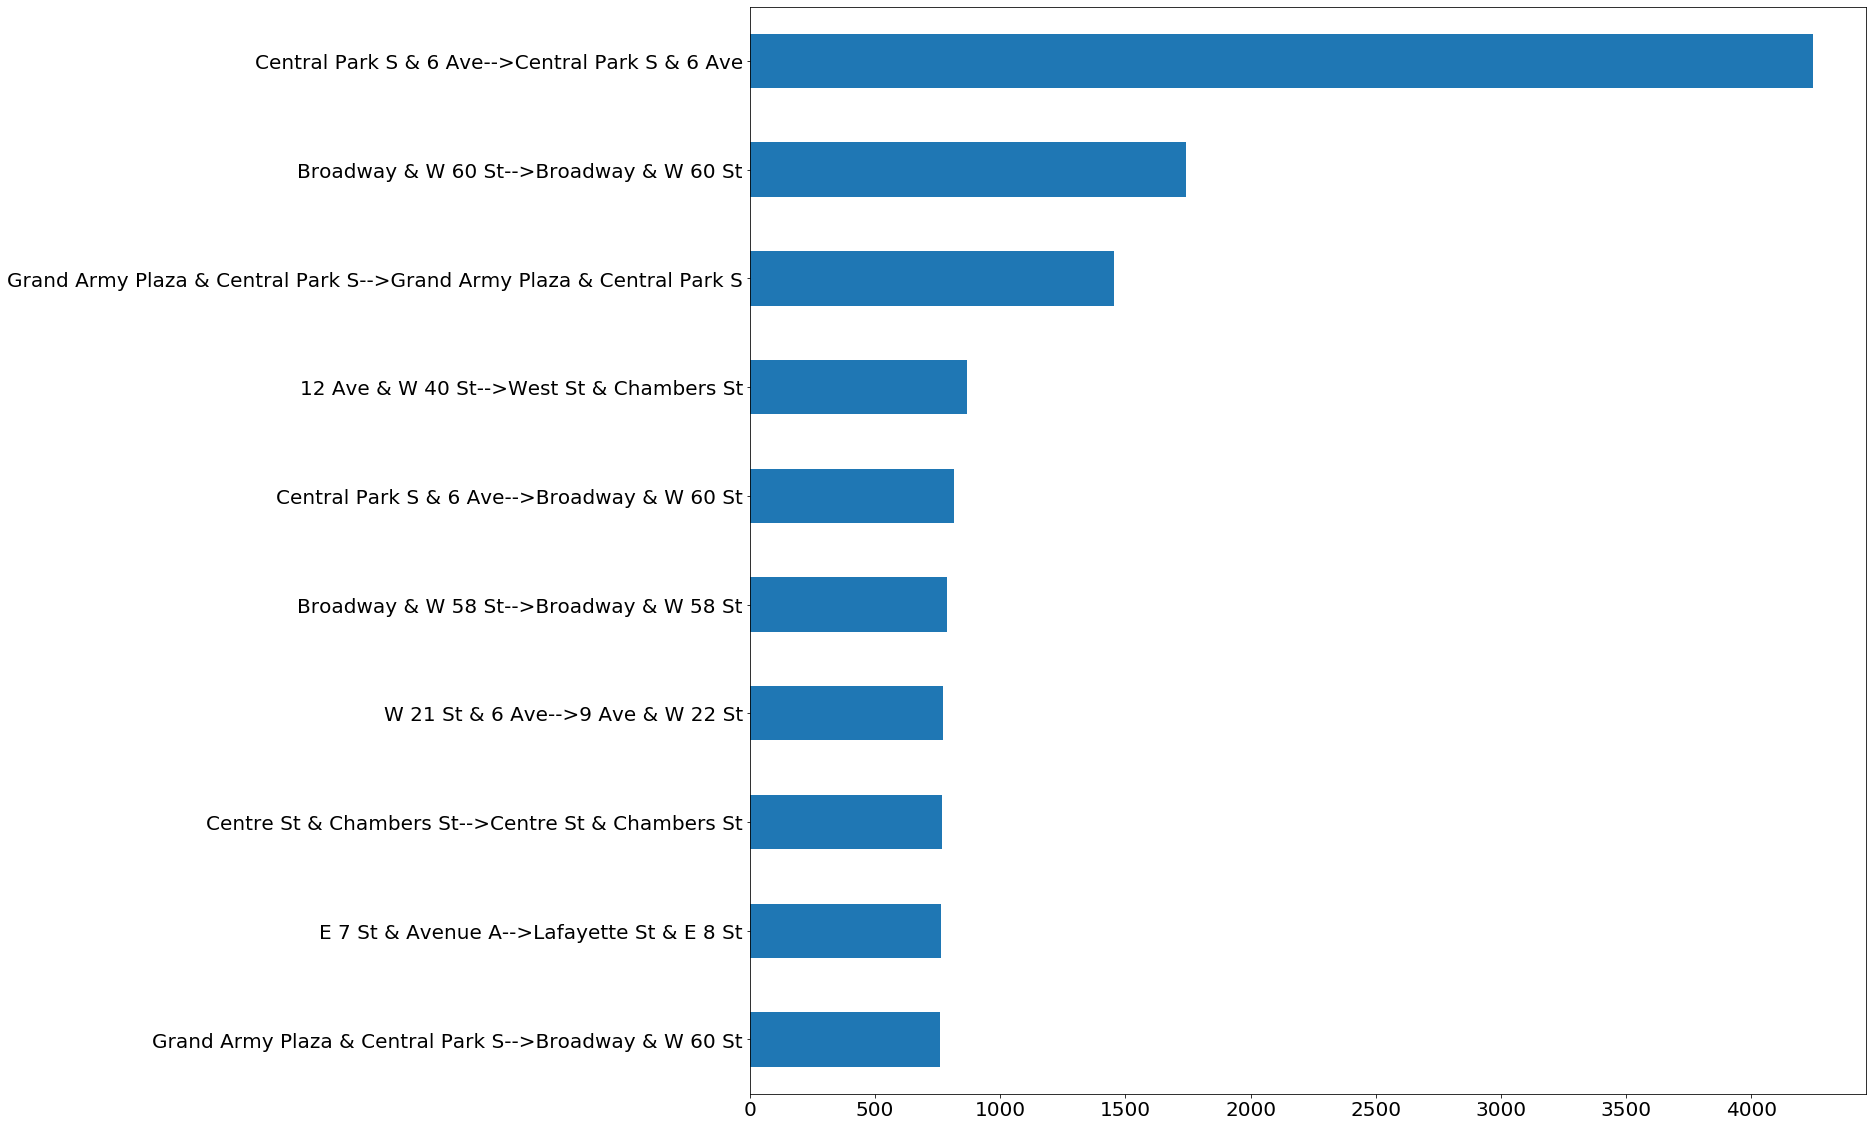

In [14]:
df["route"] = df["start station name"] + "-->" + df["end station name"]
df["route"].value_counts().sort_values(ascending = True)[-10:].plot.barh(figsize = (20,20), fontsize = 20)

plt.show()

In [19]:
test = copy.deepcopy(df)

In [20]:
test["hour bin"] = df["starttime"].dt.hour
test["day of the week"] = df["starttime"].dt.weekday

le = preprocessing.LabelEncoder()
le.fit(test["route"])
test["route numerical"] = le.transform(test["route"])

test_td_bin = np.linspace(test["trip duration minutes"].min(), 60, 14)
test["trip duration bin"] = pd.cut(x = test["trip duration minutes"], bins = test_td_bin).cat.codes

"""
test_distance_bin = np.linspace(test["distance traveled"].min(), 14, 14)
test["distance traveled bin"] = pd.cut(x = test["distance traveled"], bins = test_distance_bin)
"""

"""
test.loc[(16 <= test["age"]) & (test["age"]< 20), "age bins"] = 10
test.loc[(20 <= test["age"]) & (test["age"]< 30), "age bins"] = 20
test.loc[(30 <= test["age"]) & (test["age"]< 40), "age bins"] = 30
test.loc[(40 <= test["age"]) & (test["age"]< 50), "age bins"] = 40
test.loc[(50 <= test["age"]) & (test["age"]< 60), "age bins"] = 50
test.loc[(60 <= test["age"]) & (test["age"]< 70), "age bins"] = 60
test.loc[(70 <= test["age"]) & (test["age"]< 80), "age bins"] = 70
test["age bins"].fillna("other", inplace = True)
"""

test.loc[(16 <= test["age"]) & (test["age"]< 35), "age bins"] = 10
test.loc[(35 <= test["age"]) & (test["age"]< 80), "age bins"] = 20

test.loc[(0 <= test["distance traveled"]) & (test["distance traveled"]< 1.2), "distance traveled bin"] = 10
test.loc[(1.2 <= test["distance traveled"]) & (test["distance traveled"]< 11), "distance traveled bin"] = 20

In [105]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(test[["trip duration bin", "start station id", "distance traveled bin"]],test["user type number"], test_size = 0.20, random_state = 42)
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\Michael Ip\Anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [106]:
calculated_coeff = model.coef_
logistic_prediction = model.predict(X_test)
print (logistic_prediction)
print (model.score(X_test, y_test))

[1 1 1 ... 1 1 1]
0.857697691993211


In [24]:
df["usertype"].value_counts()/df.shape[0]

Subscriber    0.855203
Customer      0.144797
Name: usertype, dtype: float64

In [107]:
from sklearn.metrics import average_precision_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_score = model.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
print (classification_report(y_test, logistic_prediction))
print (average_precision)
print (confusion_matrix(y_test, logistic_prediction))


              precision    recall  f1-score   support

           0       0.54      0.11      0.18     46687
           1       0.87      0.98      0.92    276189

    accuracy                           0.86    322876
   macro avg       0.70      0.55      0.55    322876
weighted avg       0.82      0.86      0.82    322876

0.9067511042502724
[[  5099  41588]
 [  4358 271831]]


In [108]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(random_state = 0)
classifier.fit(X_train, y_train)
tree_prediction = classifier.predict(X_test)
print (tree_prediction)
print (classifier.score(X_test, y_test))

[0 1 1 ... 1 1 0]
0.8810967677994028


In [109]:
from sklearn.metrics import average_precision_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#y_score = classifier.decision_function(X_test)
#average_precision = average_precision_score(y_test, y_score)
print (classification_report(y_test, tree_prediction))
print (confusion_matrix(y_test, tree_prediction))


              precision    recall  f1-score   support

           0       0.66      0.37      0.47     46687
           1       0.90      0.97      0.93    276189

    accuracy                           0.88    322876
   macro avg       0.78      0.67      0.70    322876
weighted avg       0.87      0.88      0.87    322876

[[ 17178  29509]
 [  8882 267307]]


In [110]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 10)
clf.fit(X_train, y_train)
forest_prediction = clf.predict(X_test)
print (classification_report(y_test, forest_prediction))

              precision    recall  f1-score   support

           0       0.67      0.36      0.46     46687
           1       0.90      0.97      0.93    276189

    accuracy                           0.88    322876
   macro avg       0.78      0.66      0.70    322876
weighted avg       0.87      0.88      0.87    322876



In [46]:
print (np.mean(forest_prediction == y_test) * 100)
print (confusion_matrix(y_test, forest_prediction))

87.0002725504528
[[ 13584  33103]
 [  8870 267319]]


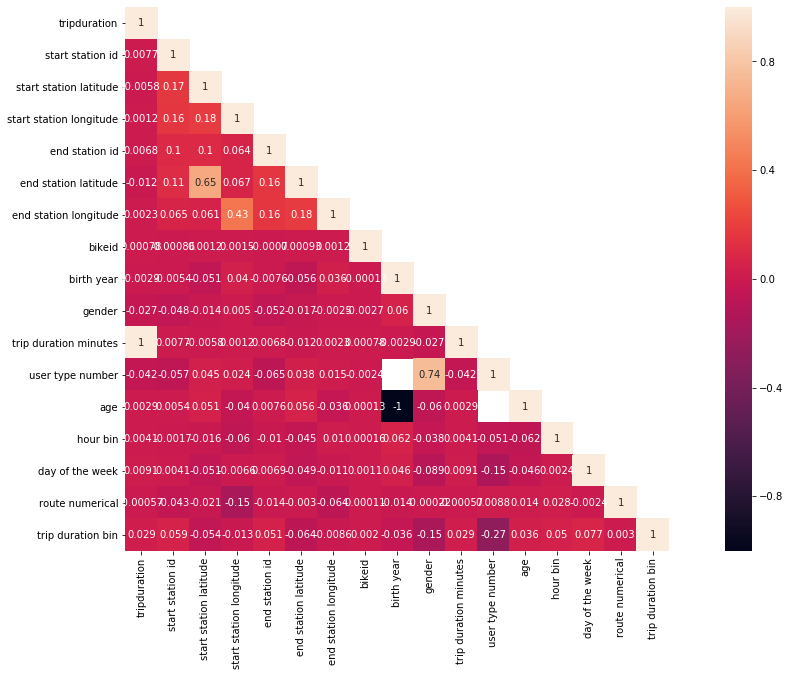

In [61]:
corrMatt = test.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=1, vmin = -1, square=True,annot=True)

In [21]:
test2 = copy.deepcopy(test)

In [22]:
test2 = test2.dropna()

In [23]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(test2[["hour bin", "trip duration bin","start station id", "route numerical", "distance traveled bin"]],test2["age bins"], test_size = 0.2, random_state = 42)
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\Michael Ip\Anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

classifier = RandomForestClassifier(n_estimators = 10, random_state = 0)
classifier.fit(X_train, y_train)
forest_prediction = classifier.predict(X_test)
#print (forest_prediction)
print (classifier.score(X_test, y_test))
print (classification_report(y_test, forest_prediction))
print (confusion_matrix(y_test, forest_prediction))

0.6508255178511894
              precision    recall  f1-score   support

        10.0       0.60      0.60      0.60    121447
        20.0       0.69      0.69      0.69    154501

    accuracy                           0.65    275948
   macro avg       0.65      0.65      0.65    275948
weighted avg       0.65      0.65      0.65    275948

[[ 72680  48767]
 [ 47587 106914]]


In [26]:
test2["age bins"].value_counts()/test2.shape[0]

20.0    0.56126
10.0    0.43874
Name: age bins, dtype: float64